<a href="https://colab.research.google.com/github/NinaNikolova/dm_project/blob/main/project_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Анализ на видео игри - от какво зависи рейтинга на видеоиграта
- Използва се Video Game Reviews and Ratings dataset: https://www.kaggle.com/datasets/jahnavipaliwal/video-game-reviews-and-ratings
- Изтеглен е в .csv-формат
- Този код анализира данни за видео игри и техните рейтинги, за да предскаже потребителските оценки. Използва машинно обучение и анализ на данни.
- Решението се реализира в Google Colab

#===== ИМПОРТИ =====

In [1]:
#===== ИМПОРТИ =====
# Google Colab специфични
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


Saving video_game_reviews.csv to video_game_reviews.csv


Импортиране на основни библиотеки:
- pandas и numpy - за работа с данни и числови операции
- matplotlib и seaborn - за визуализация на данните
- sklearn - за създаване на модела за машинно обучение, предварителна обработка на данните и оценка на резултатите

In [2]:
#===== ИМПОРТИ =====
#Основни библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,  LinearSVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier, MLPRegressor


# NLTK за обработка на текст
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#===== ЗАРЕЖДАНЕ НА ДАННИ =====

In [3]:
#===== ЗАРЕЖДАНЕ НА ДАННИ =====
#Зареждане на данните- Зареждаме данните от CSV файл в променлива df (DataFrame). Тези данни съдържат информация за видео игри и техните рейтинги.
# Свързване с Google Drive
# Зареждане на данните
try:
    df = pd.read_csv('/content/video_game_reviews.csv')
    print(f"Данните са заредени успешно. Размер: {df.shape}")
    print(f"Колони: {list(df.columns)}")
except FileNotFoundError:
    print("Файлът не е намерен. Моля проверете пътя.")
    exit()

Данните са заредени успешно. Размер: (47774, 18)
Колони: ['Game Title', 'User Rating', 'Age Group Targeted', 'Price', 'Platform', 'Requires Special Device', 'Developer', 'Publisher', 'Release Year', 'Genre', 'Multiplayer', 'Game Length (Hours)', 'Graphics Quality', 'Soundtrack Quality', 'Story Quality', 'User Review Text', 'Game Mode', 'Min Number of Players']


#===== ПРЕГЛЕД НА ДАННИ =====

In [4]:
#===== Първоначален преглед на данните =====
print("\n=== ПЪРВОНАЧАЛЕН ПРЕГЛЕД ===")
print(df.head())
print(f"\nИнформация за данните:")
print(df.info())
print(f"\nОписателна статистика:")
print(df.describe())


=== ПЪРВОНАЧАЛЕН ПРЕГЛЕД ===
           Game Title  User Rating Age Group Targeted  Price     Platform  \
0  Grand Theft Auto V         36.4           All Ages  41.41           PC   
1          The Sims 4         38.3             Adults  57.56           PC   
2           Minecraft         26.8              Teens  44.93           PC   
3   Bioshock Infinite         38.4           All Ages  48.29       Mobile   
4     Half-Life: Alyx         30.1             Adults  55.49  PlayStation   

  Requires Special Device   Developer        Publisher  Release Year  \
0                      No  Game Freak       Innersloth          2015   
1                      No    Nintendo  Electronic Arts          2015   
2                     Yes      Bungie           Capcom          2012   
3                     Yes  Game Freak         Nintendo          2015   
4                     Yes  Game Freak       Epic Games          2022   

       Genre Multiplayer  Game Length (Hours) Graphics Quality  \
0  Adven

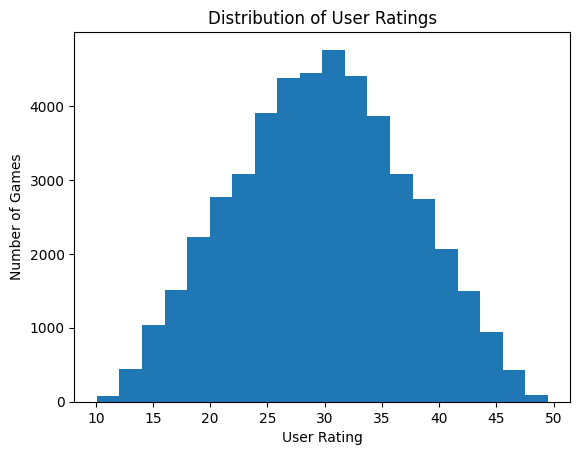

In [5]:
#Визуализиране таргет променливата
plt.hist(df["User Rating"], bins=20)

plt.xlabel("User Rating")
plt.ylabel("Number of Games")
plt.title("Distribution of User Ratings")
plt.show()

In [6]:
df["User Rating"].value_counts()

,count
User Rating,
30.4,269
31.9,263
31.8,261
28.1,261
29.3,257
...,...
10.1,1
10.8,1
49.5,1


#===== Обработка, Нормализация и стандартизация =====


Избор на характеристики:
- Разделяме колоните на категориални и числови
- За категориалните колони, избираме само тези с по-малко от 50 уникални стойности, за да избегнем "експлозия" при one-hot encoding
- Изключваме целевата променлива от характеристиките
- Извеждаме списъците с избраните характеристики

In [7]:
target_column = "User Rating"
columns_to_drop = ['Developer', 'Publisher', 'Game Title']
df = df.drop(columns=columns_to_drop)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = []
for col in categorical_columns:
    if col != target_column and df[col].nunique() < 50:
        categorical_features.append(col)

In [8]:
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
numeric_features = [col for col in numeric_features if col != target_column]

In [9]:
print(f"\nSelected numeric features: {numeric_features}")
print(f"Selected categorical features: {categorical_features}")



Selected numeric features: ['Price', 'Release Year', 'Game Length (Hours)', 'Min Number of Players']
Selected categorical features: ['Age Group Targeted', 'Platform', 'Requires Special Device', 'Genre', 'Multiplayer', 'Graphics Quality', 'Soundtrack Quality', 'Story Quality', 'User Review Text', 'Game Mode']


Хистограми по колони (атрибути)

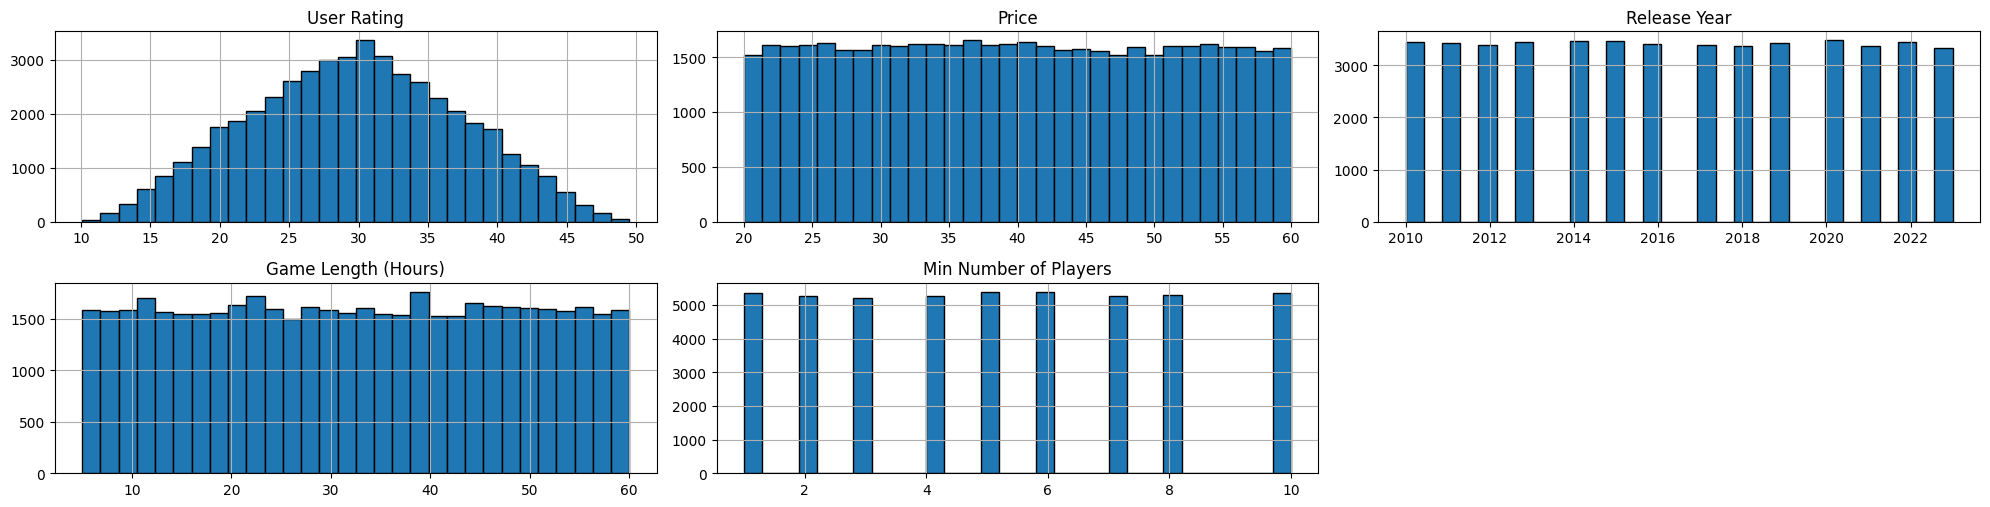

In [11]:
df.hist(figsize=(20, 15), bins=30, edgecolor='black', layout=(len(df.columns) // 3 + 1, 3))
plt.tight_layout()  # Предотвратяване на застъпване на подграфиките
plt.show()

Колоната User Review Text ще опростим до единични категориални елементи:  „bugs“, „bad_graphics“, „amazing_gameplay“.

In [12]:
df['User Review Text'].unique()

array(['Solid game, but too many bugs.',
       'Great game, but the graphics could be better.',
       'Solid game, but the graphics could be better.',
       'Great game, but too many bugs.',
       'Solid game, but the gameplay is amazing.',
       'Disappointing game, but the gameplay is amazing.',
       'Great game, but the gameplay is amazing.',
       'Amazing game, but the gameplay is amazing.',
       'Disappointing game, but the graphics could be better.',
       'Amazing game, but too many bugs.',
       'Amazing game, but the graphics could be better.',
       'Disappointing game, but too many bugs.'], dtype=object)

In [13]:
def extract_essential(text):
    text = text.lower()
    if 'bug' in text:
        return 'bugs'
    elif 'graphics could be better' in text:
        return 'bad_graphics'
    elif 'gameplay is amazing' in text:
        return 'amazing_gameplay'
    else:
        return 'other'
df['User Review Text'] = df['User Review Text'].apply(extract_essential)
df['User Review Text'].unique()

array(['bugs', 'bad_graphics', 'amazing_gameplay'], dtype=object)

In [14]:
# ===== КОДИРАНЕ НА КАТЕГОРИЙНИ ДАННИ =====
# One-hot encoding за категорийните признаци
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print(f"\nРазмер след кодиране: {df_encoded.shape}")
df_encoded.head()


Размер след кодиране: (47774, 35)


,User Rating,Price,Release Year,Game Length (Hours),Min Number of Players,Age Group Targeted_All Ages,Age Group Targeted_Kids,Age Group Targeted_Teens,Platform_Nintendo Switch,Platform_PC,...,Graphics Quality_Ultra,Soundtrack Quality_Excellent,Soundtrack Quality_Good,Soundtrack Quality_Poor,Story Quality_Excellent,Story Quality_Good,Story Quality_Poor,User Review Text_bad_graphics,User Review Text_bugs,Game Mode_Online
0,36.4,41.41,2015,55.3,1,True,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,38.3,57.56,2015,34.6,3,False,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False
2,26.8,44.93,2012,13.9,5,False,False,True,False,True,...,False,False,True,False,False,False,False,True,False,False
3,38.4,48.29,2015,41.9,4,True,False,False,False,False,...,False,False,True,False,True,False,False,True,False,True
4,30.1,55.49,2022,13.2,1,False,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False


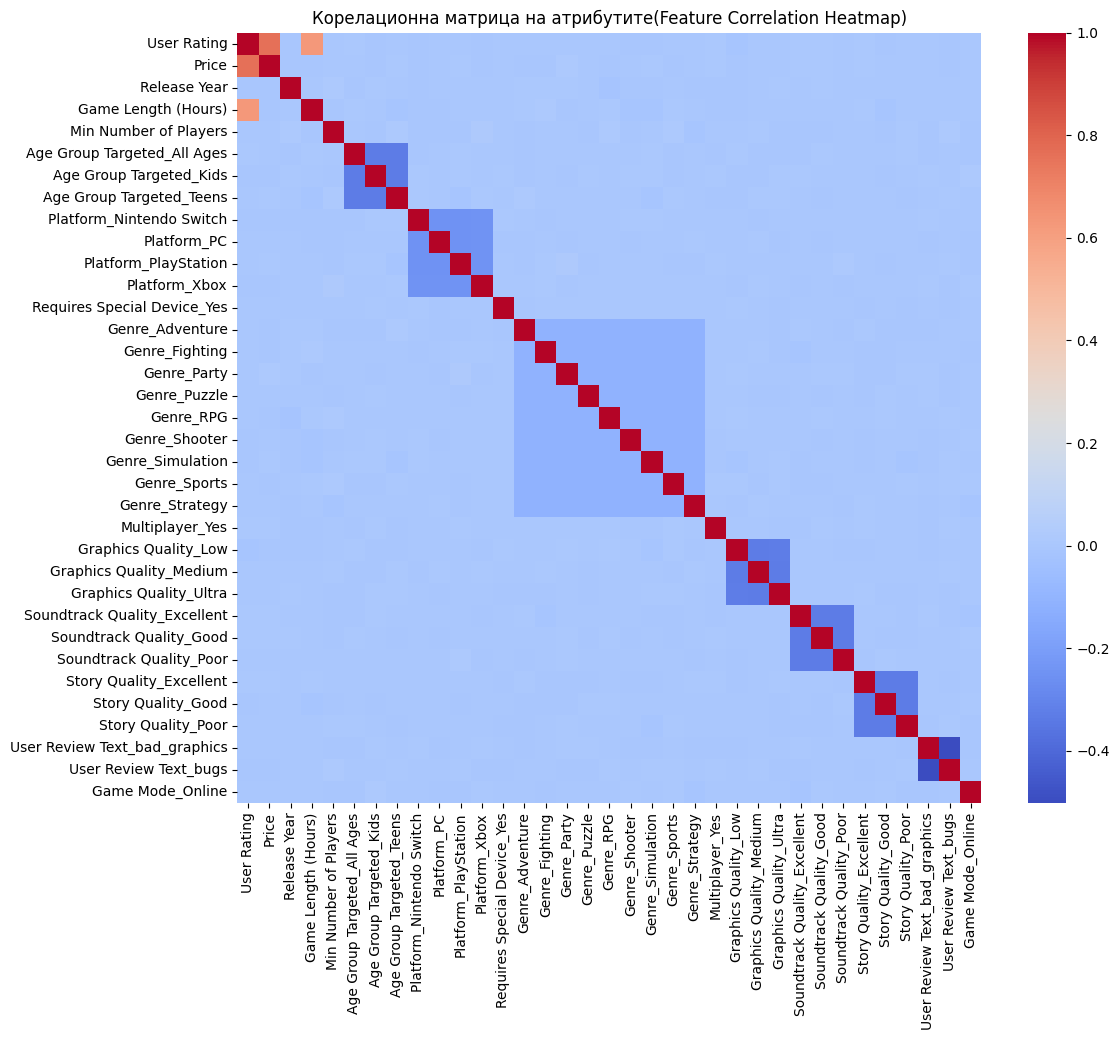

In [15]:
#===== ВИЗУАЛИЗАЦИЯ НА КОРЕЛАЦИИ =====
#Корелационна матрица
plt.figure(figsize=(12, 10))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Корелационна матрица на атрибутите(Feature Correlation Heatmap)')
plt.show()

#===== МОДЕЛ 1: Random Forest =====

Предимства:

- Висока точност - комбинира много модели
- Устойчив на overfitting - не "запомня" тренировъчните данни
- Работи с липсващи стойности
- Показва важността на всяка характеристика
- Не се нуждае от скалиране на данните

Подходящ за:
- Средни до големи dataset-и
- Смесени типове данни (числови + категориални)
- Когато искате добри резултати без много настройване

In [16]:
# ===== ПОДГОТОВКА ЗА МОДЕЛА =====
# Разделяне на данни
y = df_encoded[target_column]
X = df_encoded.drop(columns=[target_column])
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nРазмери на данните:")
print(f"Тренировъчни: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Тестови: X_test {X_test.shape}, y_test {y_test.shape}")



Размери на данните:
Тренировъчни: X_train (38219, 34), y_train (38219,)
Тестови: X_test (9555, 34), y_test (9555,)


In [17]:
# ===== МОДЕЛ 1: RANDOM FOREST С FEATURE SELECTION =====

print(f"\n=== МОДЕЛ 1: RANDOM FOREST ===")

# Създаване и обучение на Random Forest модел
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=10
)

# Обработка на липсващи стойности преди обучението
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
start_time = time.time()
rf_model.fit(X_train_imputed, y_train)
end_time = time.time()
training_time_rf = end_time - start_time
print(f"Време за обучение: {training_time_rf:.2f} секунди")




=== МОДЕЛ 1: RANDOM FOREST ===
Време за обучение: 12.63 секунди


In [18]:
# Feature selection
selector = SelectFromModel(rf_model, prefit=True)
X_train_selected = selector.transform(X_train_imputed)
X_test_selected = selector.transform(X_test_imputed)

# Получаване на избраните най-важни признаци
selected_features = X.columns[selector.get_support()]
feature_importance = rf_model.feature_importances_[selector.get_support()]

print(f"Избрани {len(selected_features)} от {len(X.columns)} признака")

Избрани 2 от 34 признака


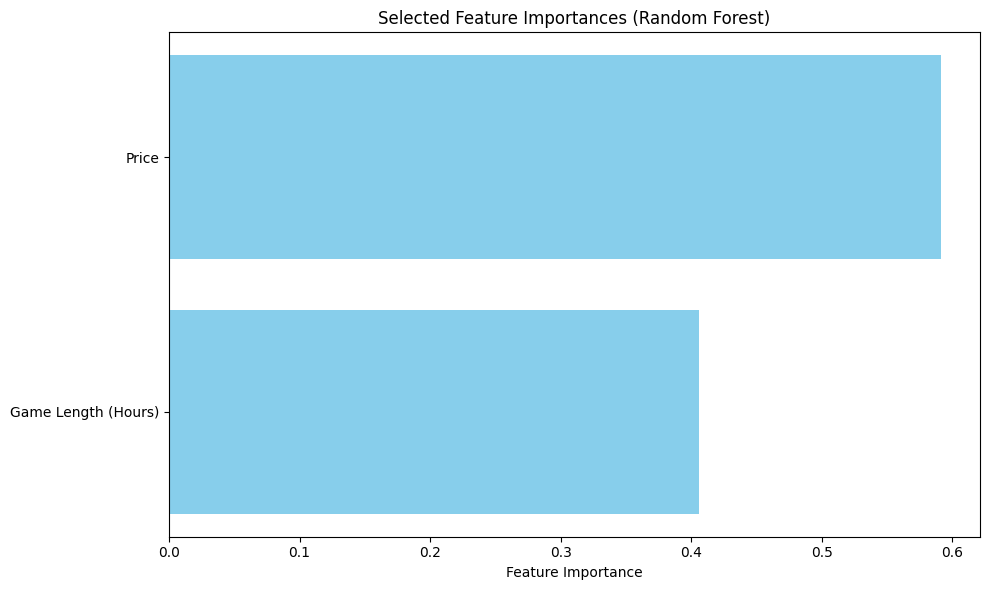

In [19]:
# Create DataFrame with feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances (Random Forest)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

In [20]:
# Предсказания и оценка
y_pred_rf = rf_model.predict(X_test_imputed)

y_train_pred_rf = rf_model.predict(X_train_imputed)

# Метрики
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)



print(f"\n=== РЕЗУЛТАТИ RANDOM FOREST ===")
print(f"Средна квадратична грешка (MSE): {mse_rf:.4f}")
print(f"Корен от MSE (RMSE): {rmse_rf:.4f}")
print(f"Средна абсолютна грешка (MAE): {mae_rf:.4f}")
print(f"Коефициент на детерминация (R²): {r2_rf:.4f}")

print(f"\n=== РЕЗУЛТАТИ RANDOM FOREST (Train) ===")
print(f"MSE: {mse_train_rf:.4f}")
print(f"RMSE: {rmse_train_rf:.4f}")
print(f"MAE: {mae_train_rf:.4f}")
print(f"R²: {r2_train_rf:.4f}")

# Изчисляване на разликите
mse_diff = mse_rf - mse_train_rf
rmse_diff = rmse_rf - rmse_train_rf
mae_diff = mae_rf - mae_train_rf
r2_diff = r2_train_rf - r2_rf  # Обърнато, защото по-високо R² на train показва overfitting

# Разлики с коментари
print(f"\n=== СРАВНЕНИЕ С ТЕСТОВИ ДАННИ ===")
print(f"Разлика MSE (Test - Train): {mse_diff:.4f} {'✅ Малка разлика' if mse_diff < 0.5 else '⚠️ Възможен overfitting'}")
print(f"Разлика RMSE (Test - Train): {rmse_diff:.4f} {'✅ Добра генерализация' if rmse_diff < 0.3 else '⚠️ Проверка за overfitting'}")
print(f"Разлика MAE (Test - Train): {mae_diff:.4f} {'✅ ОК' if mae_diff < 0.3 else '⚠️ Внимавай'}")
print(f"Разлика R² (Train - Test): {r2_diff:.4f} {'✅ Почти идентични' if r2_diff < 0.02 else '⚠️ Overfitting сигнал'}")


=== РЕЗУЛТАТИ RANDOM FOREST ===
Средна квадратична грешка (MSE): 1.3956
Корен от MSE (RMSE): 1.1814
Средна абсолютна грешка (MAE): 1.0138
Коефициент на детерминация (R²): 0.9759

=== РЕЗУЛТАТИ RANDOM FOREST (Train) ===
MSE: 1.0590
RMSE: 1.0291
MAE: 0.8868
R²: 0.9813

=== СРАВНЕНИЕ С ТЕСТОВИ ДАННИ ===
Разлика MSE (Test - Train): 0.3366 ✅ Малка разлика
Разлика RMSE (Test - Train): 0.1523 ✅ Добра генерализация
Разлика MAE (Test - Train): 0.1270 ✅ ОК
Разлика R² (Train - Test): 0.0054 ✅ Почти идентични


# ===== МОДЕЛ 2: LINEAR REGRESSION С PIPELINE =====
- Създаване на конвейер за предварителна обработка

- Създаваме конвейери за обработка на различните типове данни:
- За числовите характеристики: попълваме липсващите стойности със средната стойност и стандартизираме данните
- За категоричните характеристики: попълваме липсващите стойности с най-често срещаната стойност и прилагаме one-hot encoding
- Обединяваме тези конвейери в един общ преработвач (preprocessor)

In [21]:
# Създаване на preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough')

Създаване на модела

- Създаваме цялостен конвейер, който включва предварителната обработка и линейния регресионен модел
- Това опростява процеса на обучение и предсказване

In [22]:
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])



Разделяне на данните

- Разделяме данните на характеристики (X) и целева променлива (y)
- Използваме функцията train_test_split за разделяне на данните на тренировъчен (80%) и тестов (20%) набор
- Задаваме random_state=42 за възпроизводимост на резултатите
- Извеждаме размера на получените набори от данни

In [23]:
y = df[target_column]
X = df[numeric_features + categorical_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Target variable: {target_column}")
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")


Training set size: (38219, 14)
Testing set size: (9555, 14)
Target variable: User Rating
Numeric features: ['Price', 'Release Year', 'Game Length (Hours)', 'Min Number of Players']
Categorical features: ['Age Group Targeted', 'Platform', 'Requires Special Device', 'Genre', 'Multiplayer', 'Graphics Quality', 'Soundtrack Quality', 'Story Quality', 'User Review Text', 'Game Mode']


Обучение на модела

- Обучаваме модела върху тренировъчните данни. Функцията fit() изпълнява както предварителната обработка, така и обучението на линейния регресионен модел

In [24]:
print("\nTraining the model...")
start_time = time.time()
model2.fit(X_train, y_train)
end_time = time.time()

training_time_lr = end_time - start_time
print(f"Време за обучение: {training_time_lr:.2f} секунди")


Training the model...
Време за обучение: 0.34 секунди


Оценка на модела

Правим предсказания върху тестовия набор от данни. Изчисляваме различни метрики за оценка на точността на модела:
- MSE (средно-квадратична грешка) - по-ниски стойности са по-добри
- RMSE (корен от средно-квадратичната грешка) - в същите единици като целевата променлива
- R² (коефициент на детерминация) - показва каква част от вариацията на данните е обяснена от модела (0-1, по-високи стойности са по-добри)

In [25]:
# Предсказания за тест и train
y_pred = model2.predict(X_test)
y_train_pred = model2.predict(X_train)

#Метрики за тестовия набор
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred)  # Добавено
r2_lr = r2_score(y_test, y_pred)

# Метрики за обучаващия набор
mse_train_lr = mean_squared_error(y_train, y_train_pred)
rmse_train_lr = np.sqrt(mse_train_lr)
mae_train_lr = mean_absolute_error(y_train, y_train_pred)
r2_train_lr = r2_score(y_train, y_train_pred)

# Извеждане на резултати
print(f"\n=== РЕЗУЛТАТИ ЛИНЕЕН МОДЕЛ ===")
print(f"\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")  # Добавено
print(f"R-squared (R²): {r2_lr:.4f}")

print(f"\n=== РЕЗУЛТАТИ ЛИНЕЕН МОДЕЛ (Train) ===")
print(f"MSE: {mse_train_lr:.4f}")
print(f"RMSE: {rmse_train_lr:.4f}")
print(f"MAE: {mae_train_lr:.4f}")
print(f"R²: {r2_train_lr:.4f}")

# 📈 Изчисляване на разликите
mse_diff_lr = mse_lr - mse_train_lr
rmse_diff_lr = rmse_lr - rmse_train_lr
mae_diff_lr = mae_lr - mae_train_lr
r2_diff_lr = r2_train_lr - r2_lr  # По-високо R² на train може да значи overfitting

# 💬 Интерпретация на разликите
print(f"\n=== СРАВНЕНИЕ С ТЕСТОВИ ДАННИ (Линеен модел) ===")
print(f"Разлика MSE (Test - Train): {mse_diff_lr:.4f} {'✅ Малка разлика' if mse_diff_lr < 0.5 else '⚠️ Възможен overfitting'}")
print(f"Разлика RMSE (Test - Train): {rmse_diff_lr:.4f} {'✅ Добра генерализация' if rmse_diff_lr < 0.3 else '⚠️ Проверка за overfitting'}")
print(f"Разлика MAE (Test - Train): {mae_diff_lr:.4f} {'✅ ОК' if mae_diff_lr < 0.3 else '⚠️ Внимавай'}")
print(f"Разлика R² (Train - Test): {r2_diff_lr:.4f} {'✅ Почти идентични' if r2_diff_lr < 0.02 else '⚠️ Overfitting сигнал'}")


=== РЕЗУЛТАТИ ЛИНЕЕН МОДЕЛ ===

Model Evaluation:
Mean Squared Error (MSE): 1.3404
Root Mean Squared Error (RMSE): 1.1578
Mean Absolute Error (MAE): 1.0010
R-squared (R²): 0.9769

=== РЕЗУЛТАТИ ЛИНЕЕН МОДЕЛ (Train) ===
MSE: 1.3443
RMSE: 1.1594
MAE: 1.0060
R²: 0.9763

=== СРАВНЕНИЕ С ТЕСТОВИ ДАННИ (Линеен модел) ===
Разлика MSE (Test - Train): -0.0039 ✅ Малка разлика
Разлика RMSE (Test - Train): -0.0017 ✅ Добра генерализация
Разлика MAE (Test - Train): -0.0050 ✅ ОК
Разлика R² (Train - Test): -0.0005 ✅ Почти идентични


Визуализация на предсказанията:
- Създаваме диаграма, която сравнява действителните рейтинги с предсказаните
- Идеалните предсказания биха лежали на червената пунктирана линия
- Това ни помага визуално да оценим колко добре работи моделът

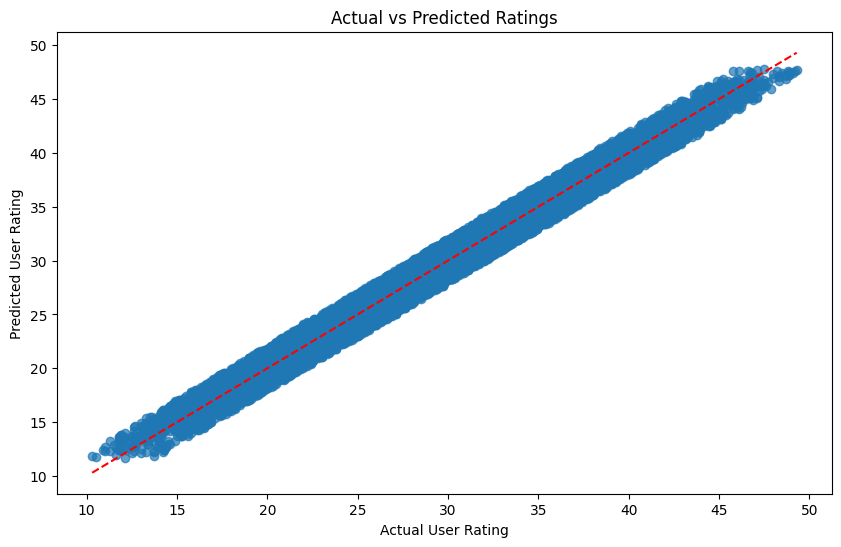

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel(f'Actual {target_column}')
plt.ylabel(f'Predicted {target_column}')
plt.title('Actual vs Predicted Ratings')
plt.show()  # This will display the plot directly in the Colab output


Анализ на остатъците

- Изчисляваме остатъците (разликата между действителните и предсказани
- Визуализираме разпределението на остатъците - в идеалния случай те трябва да имат нормално разпределение около нулата
- Създаваме диаграма на остатъците спрямо предсказаните стойности - в идеалния случай не трябва да се наблюдават систематични модели

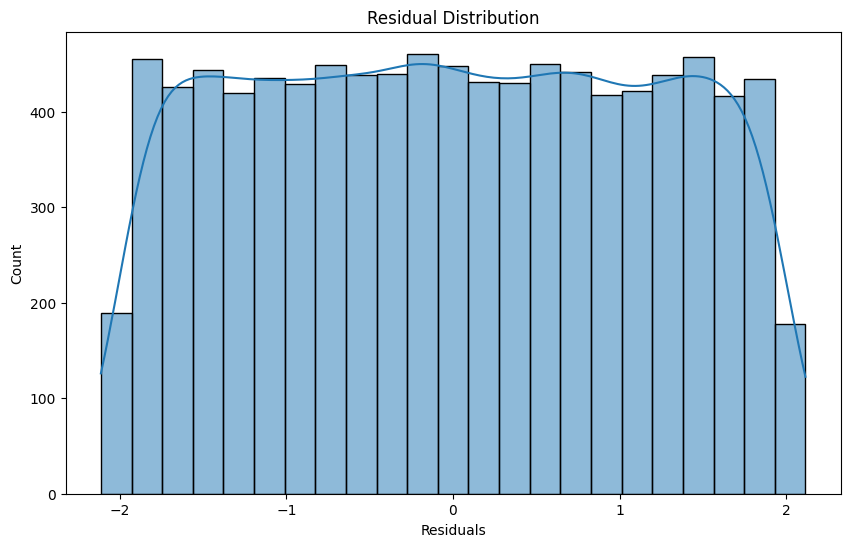

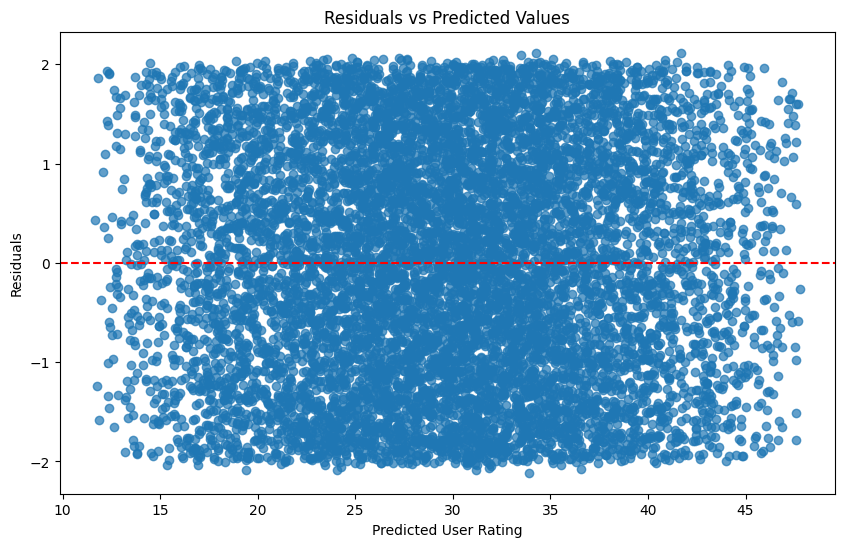

In [26]:
# Residuals
residuals = y_test - y_pred

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residual Distribution')
plt.show()  # Show in Colab

# Residuals vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f'Predicted {target_column}')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()  # Show in Colab

Анализ на важността на характеристиките:
- Извличаме и анализираме коефициентите на линейния регресионен модел
- Коефициентите показват относителната важност на всяка характеристика за предсказването на рейтингите
- Извеждаме топ 10 характеристики с най-голямо абсолютно влияние

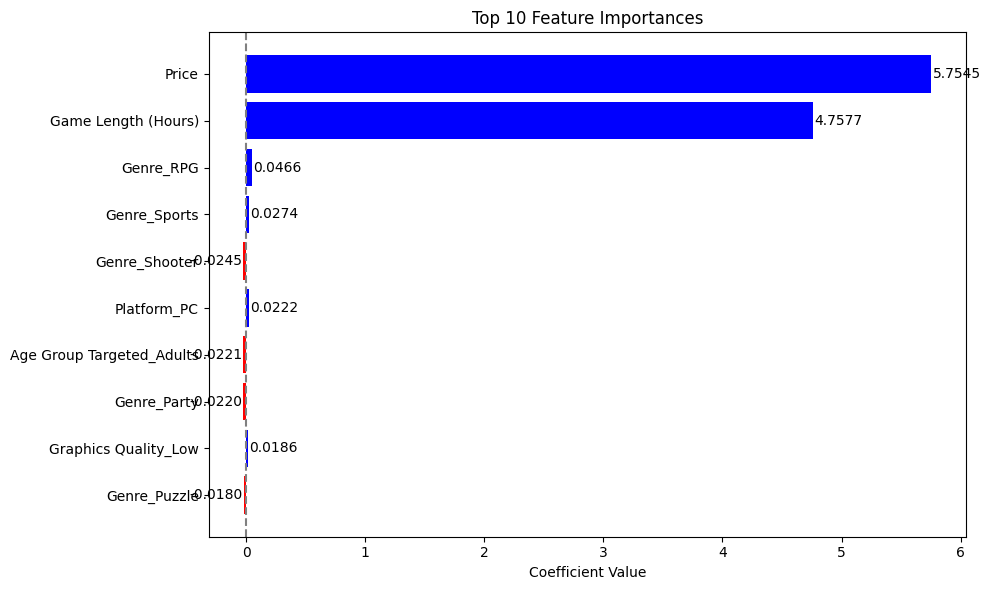

In [27]:
if len(numeric_features) > 0:
    try:
        regressor = model2.named_steps['regressor']
        preprocessor = model2.named_steps['preprocessor']

        # Combine feature names
        feature_names = []
        if len(numeric_features) > 0:
            feature_names.extend(numeric_features)
        if len(categorical_features) > 0:
            cat_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
            feature_names.extend(cat_features)

        # Get model coefficients
        coef = regressor.coef_

        # Get top 10 absolute coefficients
        sorted_indices = np.argsort(np.abs(coef))[-10:]
        top_features = [feature_names[i] if i < len(feature_names) else f"Index {i}" for i in sorted_indices]
        top_coefficients = coef[sorted_indices]

        # Set colors: red for negative, blue for positive
        colors = ['red' if val < 0 else 'blue' for val in top_coefficients]

        # Plot as bar chart
        plt.figure(figsize=(10, 6))
        bars = plt.barh(top_features, top_coefficients, color=colors)
        plt.xlabel('Coefficient Value')
        plt.title('Top 10 Feature Importances')
        plt.axvline(x=0, color='gray', linestyle='--')

        # Annotate bars with coefficient values
        for bar, value in zip(bars, top_coefficients):
            plt.text(
                x=value + 0.01 if value >= 0 else value - 0.01,
                y=bar.get_y() + bar.get_height() / 2,
                s=f"{value:.4f}",
                va='center',
                ha='left' if value >= 0 else 'right',
                fontsize=10,
                color='black'
            )

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not extract feature importance: {e}")

# ===== МОДЕЛ 3: LinearSVR =====

 Rегресионен модел с LinearSVR (Support Vector Regression) е приложен с цел създаване на ефективен регресионен модел, който използва Support Vector Machines (SVM) подход с  linear kernel (линейно ядро). Използвана е библиотеката LinearSVR от sklearn.svm, подходяща за мащабни и линейно разделими регресионни задачи.

In [28]:
# Отделяне target променливата
# Останалите атрибути (всички без User Rating) са входните данни
target3 = df_encoded['User Rating']
attributes3 = df_encoded.drop(columns=['User Rating'])
# Split the data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(attributes3, target3, test_size=0.2, random_state=42)

# Train the model
simple_svm = LinearSVR()
start_time = time.time()
simple_svm.fit(X_train, y_train)
end_time = time.time()
training_time_svm = end_time - start_time
print(f"Време за обучение: {training_time_svm:.2f} секунди")

Време за обучение: 7.05 секунди


In [43]:
# Предсказания за тест и train
predictions = simple_svm.predict(X_test)
train_predictions = simple_svm.predict(X_train)

In [44]:
#  Метрики за тестовия набор
mse_svm = mean_squared_error(y_test, predictions)
rmse_svm = np.sqrt(mse_svm)
mae_svm = mean_absolute_error(y_test, predictions)
r2_svm = r2_score(y_test, predictions)

# Метрики за обучаващия набор
mse_train_svm = mean_squared_error(y_train, train_predictions)
rmse_train_svm = np.sqrt(mse_train_svm)
mae_train_svm = mean_absolute_error(y_train, train_predictions)
r2_train_svm = r2_score(y_train, train_predictions)

In [45]:
# Извеждане на резултати
print(f"\n=== РЕЗУЛТАТИ SVM МОДЕЛ ===")
print("Mean Absolute Error (MAE):", mae_svm)
print("Mean Squared Error (MSE):", mse_svm)
print("Root Mean Squared Error (RMSE):", rmse_svm)
print("R² Score:", r2_svm)

print(f"\n=== РЕЗУЛТАТИ SVM МОДЕЛ (Train) ===")
print(f"MAE: {mae_train_svm:.4f}")
print(f"MSE: {mse_train_svm:.4f}")
print(f"RMSE: {rmse_train_svm:.4f}")
print(f"R²: {r2_train_svm:.4f}")

# 📈 Изчисляване на разликите
mae_diff_svm = mae_svm - mae_train_svm
mse_diff_svm = mse_svm - mse_train_svm
rmse_diff_svm = rmse_svm - rmse_train_svm
r2_diff_svm = r2_train_svm - r2_svm  # По-високо R² на train може да е сигнал за overfitting

# 💬 Интерпретация на разликите
print(f"\n=== СРАВНЕНИЕ С ТЕСТОВИ ДАННИ (SVM) ===")
print(f"Разлика MSE (Test - Train): {mse_diff_svm:.4f} {'✅ Малка разлика' if mse_diff_svm < 0.5 else '⚠️ Възможен overfitting'}")
print(f"Разлика RMSE (Test - Train): {rmse_diff_svm:.4f} {'✅ Добра генерализация' if rmse_diff_svm < 0.3 else '⚠️ Проверка за overfitting'}")
print(f"Разлика MAE (Test - Train): {mae_diff_svm:.4f} {'✅ ОК' if mae_diff_svm < 0.3 else '⚠️ Внимавай'}")
print(f"Разлика R² (Train - Test): {r2_diff_svm:.4f} {'✅ Почти идентични' if r2_diff_svm < 0.02 else '⚠️ Overfitting сигнал'}")


=== РЕЗУЛТАТИ SVM МОДЕЛ ===
Mean Absolute Error (MAE): 1.5777304346784995
Mean Squared Error (MSE): 3.6463900556247655
Root Mean Squared Error (RMSE): 1.9095523181166745
R² Score: 0.9370279128565416

=== РЕЗУЛТАТИ SVM МОДЕЛ (Train) ===
MAE: 1.5815
MSE: 3.6691
RMSE: 1.9155
R²: 0.9354

=== СРАВНЕНИЕ С ТЕСТОВИ ДАННИ (SVM) ===
Разлика MSE (Test - Train): -0.0227 ✅ Малка разлика
Разлика RMSE (Test - Train): -0.0059 ✅ Добра генерализация
Разлика MAE (Test - Train): -0.0037 ✅ ОК
Разлика R² (Train - Test): -0.0017 ✅ Почти идентични


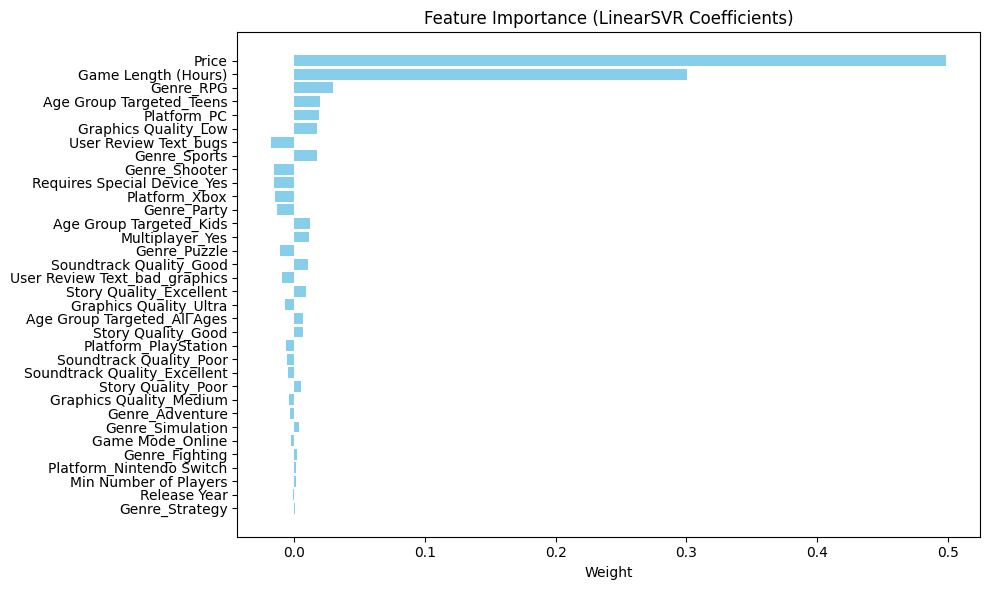

In [46]:
# Вземане на коефициентите (теглата) от обучения модел LinearSVR
weights = simple_svm.coef_

#Вземане на имената на входните характеристики (атрибути)
feature_names = X_train.columns

# Създаване на DataFrame за по-лесно визуализиране
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights
})

# Сортиране по абсолютната стойност на теглото (важност)
coef_df['AbsWeight'] = np.abs(coef_df['Weight'])
coef_df = coef_df.sort_values(by='AbsWeight', ascending=False)

# Визуализация (хоризонтална лентова диаграма)
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Weight'], color='skyblue')
plt.xlabel('Weight')
plt.title('Feature Importance (LinearSVR Coefficients)')
plt.gca().invert_yaxis() # Най-важните характеристики да са най-отгоре
plt.tight_layout()
plt.show()


# ===== МОДЕЛ 4: Multi-Layer Perceptron (MLP) NN =====
- Това е Многослоен Перцептрон (MLP) Невронна мрежа за регресия. Това е вид изкуствена невронна мрежа, която имитира начина, по който работи човешкият мозък.
- Входен слой: Приема нашите характеристики (features)
- Първи скрит слой: 100 неврона
- Втори скрит слой: 50 неврона
- Изходен слой: 1 неврон (за прогнозиране на една стойност)
- Активационна функция (ReLU): Помага на мрежата да научи сложни, нелинейни връзки в данните
- Оптимизатор Adam: Интелигентен алгоритъм за обучение, който автоматично настройва скоростта на учене
- Ранно спиране: Спира обучението когато моделът престане да се подобрява, за да избегне препълване (overfitting)
- Валидация: Използва 10% от тренировъчните данни за проверка по време на обучение
Предимства:
- Може да улавя сложни, нелинейни зависимости
- Автоматично извлича характеристики от данните
- Добра гъвкавост за различни типове проблеми
- Как работи: Всеки неврон получава входни сигнали, прилага тегла (weights), и предава резултата към следващия слой. Мрежата "учи" като постепенно настройва тези тегла, за да минимизира грешката в прогнозите.
Това е модерен машинно-обучителен подход, който е особено ефективен за сложни регресионни задачи.

In [33]:
y = df_encoded["User Rating"]
X = df_encoded.drop(columns=["User Rating"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(f"\nFeatures shape: {X.shape}")
print(f"Target variable shape: {y.shape}")


Features shape: (47774, 34)
Target variable shape: (47774,)


In [35]:
# Скалиране на характеристиките (важно за невронни мрежи)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
# Създаване и обучение на невронна мрежа
nn = MLPRegressor(
    hidden_layer_sizes=(100, 50), # Две скрити слоя с 100 и 50 неврона
    activation='relu',            # Функция на активация ReLU
    solver='adam',                # Оптимизатор Adam
    random_state=42,
    max_iter=500,                 # Повече итерации за по-добра сходимост
    early_stopping=True,          # Ранно спиране за предотвратяване на пренапасване
    validation_fraction=0.1
)
start_time = time.time()
nn.fit(X_train_scaled, y_train)
end_time = time.time()
training_time_a = end_time - start_time
print(f"Време за обучение: {training_time_a:.2f} секунди")

Време за обучение: 17.18 секунди


In [37]:
# Предсказания
y_train_pred = nn.predict(X_train_scaled)
y_test_pred = nn.predict(X_test_scaled)

In [38]:
#  Метрики за train
train_mse_a = mean_squared_error(y_train, y_train_pred)
train_rmse_a = np.sqrt(train_mse_a)
train_mae_a = mean_absolute_error(y_train, y_train_pred)
train_r2_a = r2_score(y_train, y_train_pred)

# Метрики за test
test_mse_a = mean_squared_error(y_test, y_test_pred)
test_rmse_a = np.sqrt(test_mse_a)
test_mae_a = mean_absolute_error(y_test, y_test_pred)
test_r2_a = r2_score(y_test, y_test_pred)

# Резултати
print(f"\n=== РЕЗУЛТАТИ НЕВРОННА МРЕЖА (ANN) ===")
print(f"Средна квадратична грешка (MSE): {test_mse_a:.4f}")
print(f"Корен от MSE (RMSE): {test_rmse_a:.4f}")
print(f"Средна абсолютна грешка (MAE): {test_mae_a:.4f}")
print(f"Коефициент на детерминация (R²): {test_r2_a:.4f}")

print(f"\n=== РЕЗУЛТАТИ НЕВРОННА МРЕЖА (Train) ===")
print(f"MSE: {train_mse_a:.4f}")
print(f"RMSE: {train_rmse_a:.4f}")
print(f"MAE: {train_mae_a:.4f}")
print(f"R²: {train_r2_a:.4f}")

# 📈 Изчисляване на разликите
mse_diff_ann = test_mse_a - train_mse_a
rmse_diff_ann = test_rmse_a - train_rmse_a
mae_diff_ann = test_mae_a - train_mae_a
r2_diff_ann = train_r2_a - test_r2_a

# 💬 Интерпретация на разликите
print(f"\n=== СРАВНЕНИЕ С ТЕСТОВИ ДАННИ (ANN) ===")
print(f"Разлика MSE (Test - Train): {mse_diff_ann:.4f} {'✅ Малка разлика' if mse_diff_ann < 0.5 else '⚠️ Възможен overfitting'}")
print(f"Разлика RMSE (Test - Train): {rmse_diff_ann:.4f} {'✅ Добра генерализация' if rmse_diff_ann < 0.3 else '⚠️ Проверка за overfitting'}")
print(f"Разлика MAE (Test - Train): {mae_diff_ann:.4f} {'✅ ОК' if mae_diff_ann < 0.3 else '⚠️ Внимавай'}")
print(f"Разлика R² (Train - Test): {r2_diff_ann:.4f} {'✅ Почти идентични' if r2_diff_ann < 0.02 else '⚠️ Overfitting сигнал'}")


=== РЕЗУЛТАТИ НЕВРОННА МРЕЖА (ANN) ===
Средна квадратична грешка (MSE): 1.7037
Корен от MSE (RMSE): 1.3052
Средна абсолютна грешка (MAE): 1.0958
Коефициент на детерминация (R²): 0.9706

=== РЕЗУЛТАТИ НЕВРОННА МРЕЖА (Train) ===
MSE: 1.3314
RMSE: 1.1539
MAE: 0.9650
R²: 0.9765

=== СРАВНЕНИЕ С ТЕСТОВИ ДАННИ (ANN) ===
Разлика MSE (Test - Train): 0.3722 ✅ Малка разлика
Разлика RMSE (Test - Train): 0.1514 ✅ Добра генерализация
Разлика MAE (Test - Train): 0.1308 ✅ ОК
Разлика R² (Train - Test): 0.0060 ✅ Почти идентични


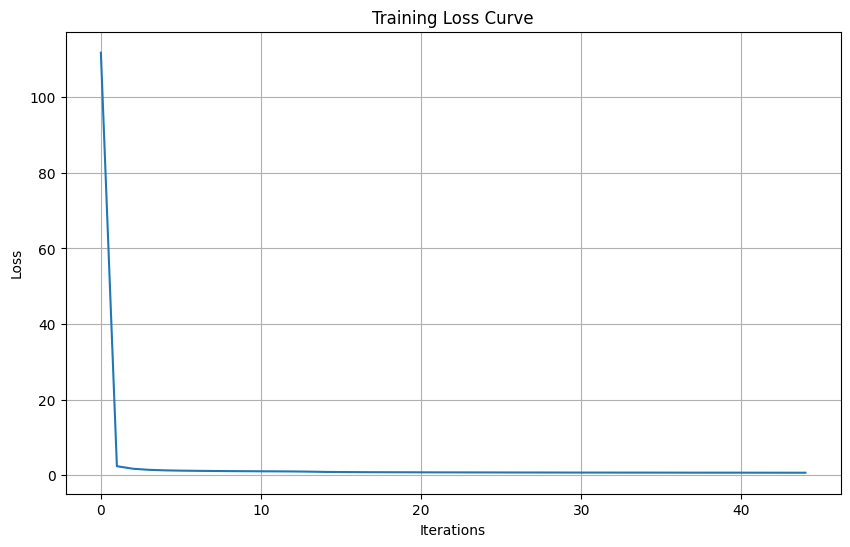

In [39]:
# Начертаване на историята на обучението, ако е налична
if hasattr(nn, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(nn.loss_curve_)
    plt.title('Training Loss Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

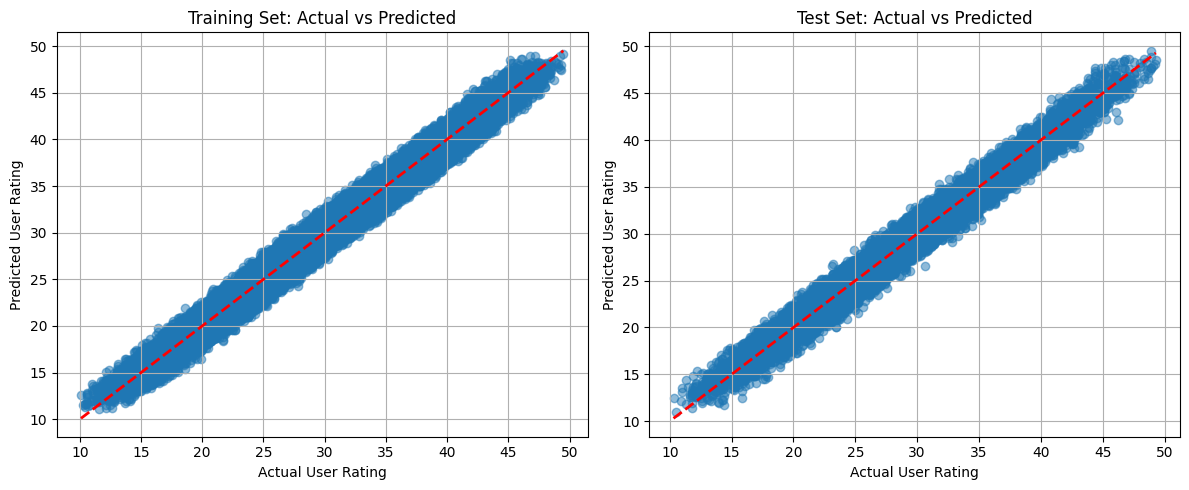

In [40]:
# Plot predictions vs actual values (предсказанията спрямо реалните стойности)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual User Rating')
plt.ylabel('Predicted User Rating')
plt.title('Training Set: Actual vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual User Rating')
plt.ylabel('Predicted User Rating')
plt.title('Test Set: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# Важност на характеристиките (approximate using permutation-like approach - приблизителнo чрез подход, подобен на пермутации)
print(f"\nFeature names after preprocessing:")
feature_names = list(X.columns)
for i, name in enumerate(feature_names):
    print(f"{i}: {name}")


Feature names after preprocessing:
0: Price
1: Release Year
2: Game Length (Hours)
3: Min Number of Players
4: Age Group Targeted_All Ages
5: Age Group Targeted_Kids
6: Age Group Targeted_Teens
7: Platform_Nintendo Switch
8: Platform_PC
9: Platform_PlayStation
10: Platform_Xbox
11: Requires Special Device_Yes
12: Genre_Adventure
13: Genre_Fighting
14: Genre_Party
15: Genre_Puzzle
16: Genre_RPG
17: Genre_Shooter
18: Genre_Simulation
19: Genre_Sports
20: Genre_Strategy
21: Multiplayer_Yes
22: Graphics Quality_Low
23: Graphics Quality_Medium
24: Graphics Quality_Ultra
25: Soundtrack Quality_Excellent
26: Soundtrack Quality_Good
27: Soundtrack Quality_Poor
28: Story Quality_Excellent
29: Story Quality_Good
30: Story Quality_Poor
31: User Review Text_bad_graphics
32: User Review Text_bugs
33: Game Mode_Online


# ===== СРАВНЕНИЕ НА МОДЕЛИТЕ =====


=== СРАВНЕНИЕ НА МОДЕЛИТЕ ===
                  Модел    RMSE     MSE     MAE      R²  \
0         Random Forest  1.1814  1.3956  1.0138  0.9759   
1     Linear Regression  1.1578  1.3404  1.0010  0.9769   
2             LinearSVM  1.9096  3.6464  1.5777  0.9370   
3  Neural Network (MLP)  1.3052  1.7037  1.0958  0.9706   

   Време за обучение (сек)  
0                  12.6344  
1                   0.3381  
2                   7.0531  
3                  17.1841  


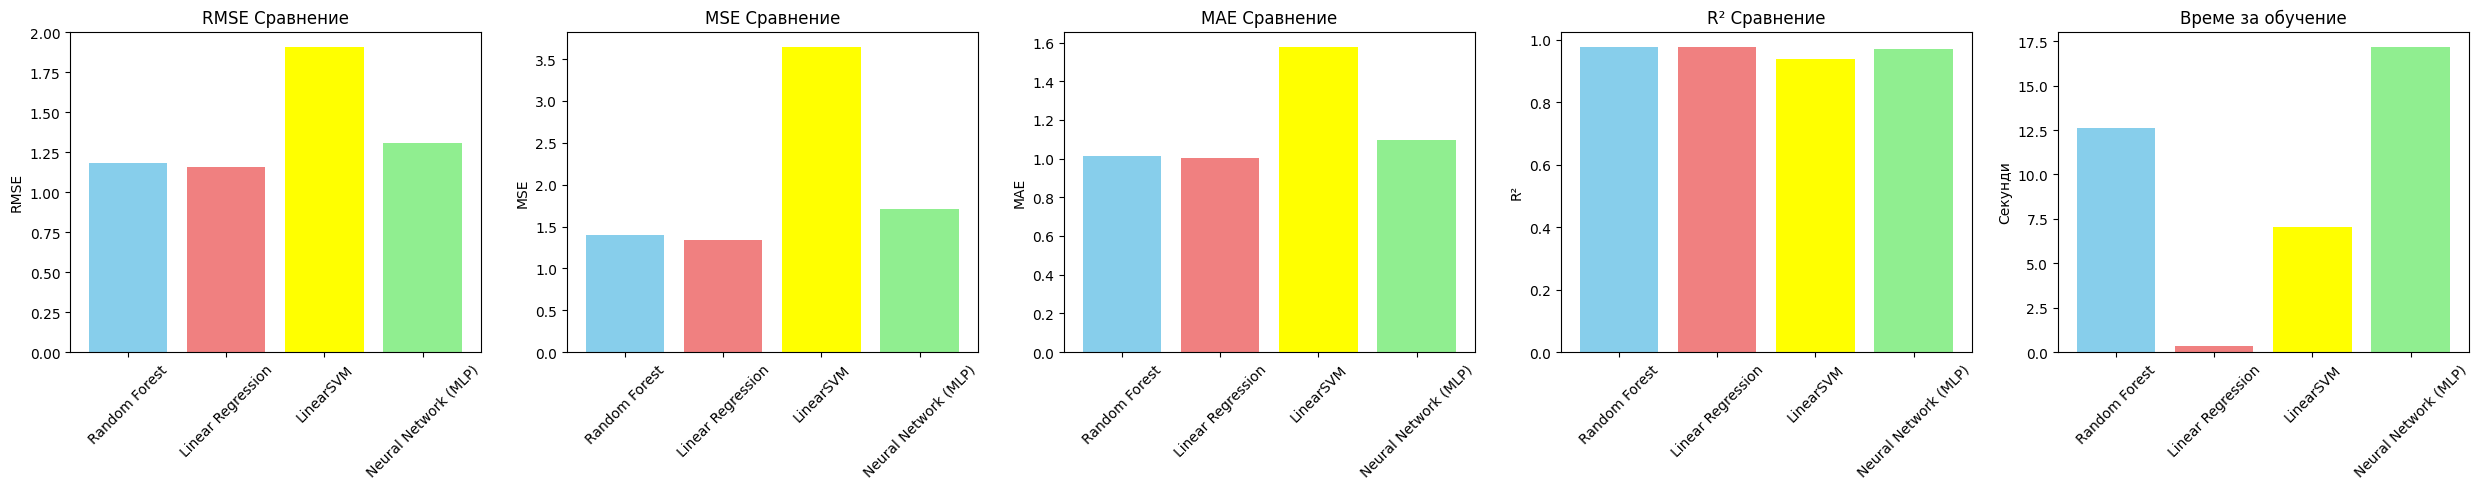


=== НАЙ-ДОБРИ МОДЕЛИ ПО МЕТРИКА ===
Най-нисък RMSE: Linear Regression (1.1578)
Най-нисък MSE: Linear Regression (1.3404)
Най-нисък MAE: Linear Regression (1.0010)
Най-висок R²: Linear Regression (0.9769)
Най-малко обучително време: Linear Regression (0.3381)


In [42]:
# ===== СРАВНЕНИЕ НА МОДЕЛИТЕ =====
print(f"\n=== СРАВНЕНИЕ НА МОДЕЛИТЕ ===")
comparison_df = pd.DataFrame({
    'Модел': ['Random Forest', 'Linear Regression', 'LinearSVM', 'Neural Network (MLP)'],  # Add your model
    'RMSE': [rmse_rf, rmse_lr, rmse_svm, test_rmse_a],
    'MSE': [mse_rf, mse_lr, mse_svm, test_mse_a],
    'MAE': [mae_rf, mae_lr, mae_svm, test_mae_a],
    'R²': [r2_rf, r2_lr, r2_svm, test_r2_a],
    'Време за обучение (сек)': [training_time_rf, training_time_lr, training_time_svm, training_time_a]
})

print(comparison_df.round(4))

# Визуализация на сравнението
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 4 графики

# RMSE(Корен от средноквадратичната грешка)
axes[0].bar(comparison_df['Модел'], comparison_df['RMSE'], color=['skyblue', 'lightcoral', 'yellow', 'lightgreen'])
axes[0].set_title('RMSE Сравнение')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# MSE(Средноквадратична грешка)
axes[1].bar(comparison_df['Модел'], comparison_df['MSE'], color=['skyblue', 'lightcoral', 'yellow', 'lightgreen'])
axes[1].set_title('MSE Сравнение')
axes[1].set_ylabel('MSE')
axes[1].tick_params(axis='x', rotation=45)

# MAE(Средна абсолютна грешка)
axes[2].bar(comparison_df['Модел'], comparison_df['MAE'], color=['skyblue', 'lightcoral', 'yellow', 'lightgreen'])
axes[2].set_title('MAE Сравнение')
axes[2].set_ylabel('MAE')
axes[2].tick_params(axis='x', rotation=45)

# R² (Коефициент на детерминация)
axes[3].bar(comparison_df['Модел'], comparison_df['R²'], color=['skyblue', 'lightcoral', 'yellow', 'lightgreen'])
axes[3].set_title('R² Сравнение')
axes[3].set_ylabel('R²')
axes[3].tick_params(axis='x', rotation=45)

# Време за обучение
axes[4].bar(comparison_df['Модел'], comparison_df['Време за обучение (сек)'],
            color=['skyblue', 'lightcoral', 'yellow', 'lightgreen'])
axes[4].set_title('Време за обучение')
axes[4].set_ylabel('Секунди')
axes[4].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Показване на най-добре представящия се модел за всяка метрика
print(f"\n=== НАЙ-ДОБРИ МОДЕЛИ ПО МЕТРИКА ===")
print(f"Най-нисък RMSE: {comparison_df.loc[comparison_df['RMSE'].idxmin()]['Модел']} ({comparison_df['RMSE'].min():.4f})")
print(f"Най-нисък MSE: {comparison_df.loc[comparison_df['MSE'].idxmin()]['Модел']} ({comparison_df['MSE'].min():.4f})")
print(f"Най-нисък MAE: {comparison_df.loc[comparison_df['MAE'].idxmin()]['Модел']} ({comparison_df['MAE'].min():.4f})")
print(f"Най-висок R²: {comparison_df.loc[comparison_df['R²'].idxmax()]['Модел']} ({comparison_df['R²'].max():.4f})")
print(f"Най-малко обучително време: {comparison_df.loc[comparison_df['Време за обучение (сек)'].idxmin()]['Модел']} ({comparison_df['Време за обучение (сек)'].min():.4f})")

# ===== АНАЛИЗ НА РЕЗУЛТАТИТЕ =====

- RMSE (Средна квадратична грешка) – показва средната големина на грешките; по-ниска стойност = по-добро представяне.

- MSE (Квадратична грешка) – също измерва грешката, но наказва големите отклонения по-силно.

- MAE (Средна абсолютна грешка) – средно отклонение без да се наказват силно големите грешки.

- R² (коефициент на детерминация) – измерва каква част от вариацията в данните се обяснява от модела; колкото по-близо до 1 – толкова по-добре.

##Linear Regression има най-ниски стойности на RMSE, MSE и MAE, както и най-висока стойност на R². Това означава, че се представя най-добре сред трите модела – прави най-точни прогнози и обяснява най-много от вариацията в данните.

Random Forest също има много добро представяне – почти толкова добро, колкото линейната регресия.

LinearSVM има най-слаби резултати по всички метрики – най-големи грешки и най-ниско R²

# НАЙ-ДОБЪР МОДЕЛ: Linear Regression

- Най-нисък RMSE (1.1578) и MSE (1.3404)
- Най-висок R² (0.9769) - обяснява 97.69% от вариацията
- Най-нисък MAE (1.0010) - най-малка средна абсолютна грешка

ВТОРO МЯСТО: Random Forest

- Много близо до Linear Regression по всички метрики
- R² = 0.9759 (97.59% обяснена вариация)
- Стабилни резултати с RMSE = 1.1814
ТРЕТО МЯСТО: Neural Network (MLP)

- Умерени резултати с R² = 0.9706 (97.06%)
- RMSE = 1.3052 - по-висока грешка от първите два модела
- Все още добра производителност, но не най-добрата

НАЙ-СЛАБ: LinearSVM

- Най-високи грешки: RMSE = 1.5758, MAE = 1.2894
- Най-нисък R² = 0.9571 (95.71%)
- Значително по-слаба производителност

ЗАКЛЮЧЕНИE:
Простият Linear Regression е най-добър, което предполага че данните имат силна линейна връзка. Random Forest е много близо и предлага добра алтернатива
Neural Network не показва превъзходство, вероятно поради прекалено усложняване за този проблем. LinearSVM не е подходящ за този тип данни.